In [1]:
import os
import glob
import re
import datetime
import glob
from datetime import date, time, timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from itertools import chain, product
from cv2 import VideoCapture, CAP_PROP_FRAME_COUNT, CAP_PROP_FPS, CAP_PROP_POS_FRAMES
import ffmpeg
from imutils.video import FileVideoStream
import time
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, export_png, export_svg
from bokeh.models import Span, DatetimeTicker, DatetimeTickFormatter, Range1d
from bokeh.palettes import Set1_9
from bokeh.layouts import gridplot
from scipy import stats
from scipy.stats import gaussian_kde
from utils import load_diffs, load_slide_changes, load_intervals
from utils import filter_video, plot_slide_diffs, get_signals, evaluate
from utils import sanitize_signals
from hmmlearn import hmm

np.random.seed(42)
sns.set()
output_notebook()

Loading BokehJS ...

In [2]:
def get_segments(l):
    start = l.pop(0)
    while l != []:
        end = l.pop(0)
        yield (start, end)
        start = end
    yield (start, None)

In [3]:
def plot_states(d, y='value_norm', state='state', time_field='time', cmap='tab10', 
                title=None, title_size=25, title_weight = 'bold', alpha=1, mk_alpha=1, 
                ax=None, legend=True, markers=False):
    if ax is None:
        ax = plt.gca()
    
    if isinstance(cmap, str):
        colors = cm.get_cmap(cmap).colors
    else:
        colors = cmap
        
    num_states = d[state].nunique()
    if num_states > len(colors):
        colors = [c for i, c in zip(range(num_states), cycle(colors))]
 
    transitions = [idx for idx, v in enumerate(d[state].diff()) if v != 0]
    for s, e in get_segments(transitions):
        clr_idx = d[state][s:e].unique().astype(int)[0]
        clr = colors[clr_idx]
        if e:
            ax.plot(d[time_field][s:e+1], d[y][s:e+1], c=clr, alpha=alpha)
        else:
            ax.plot(d[time_field][s:e], d[y][s:e], c=clr, alpha=alpha)
        if markers:    
            ax.scatter(d[time_field][s:e], d[y][s:e], color=clr, alpha=mk_alpha)
            
    if title:
        ax.set_title(title, fontsize=title_size, fontweight=title_weight)
        
    if legend:
        ax.legend(handles=[mpatches.Patch(color=c, label=s) for s, c in enumerate(colors[:num_states])],
                  loc='upper left',
                  ncol=1,
                  title='State',
                  fontsize=15,
                  title_fontsize=15)

In [4]:
def plot_hist(d, y='value_norm', state='state', time_field='time', cmap='tab10', 
              alpha=0.4, linewidth=0, ax=None):
    if ax is None:
        ax = plt.gca()
    
    if isinstance(cmap, str):
        colors = cm.get_cmap(cmap).colors
    else:
        colors = cmap
        
    num_states = d[state].nunique()
    if num_states > len(colors):
        colors = [c for i, c in zip(range(num_states), cycle(colors))]
        
    for st, group in d.groupby(state):
        if st == 0:
            sns.kdeplot(group[y], shade=True, vertical=True,
                        color=colors[st], legend=False, ax=ax, 
                        linewidth=linewidth, alpha=0.7)
        else:
            sns.kdeplot(group[y], shade=True, vertical=True,
                        color=colors[st], legend=False, ax=ax, 
                        linewidth=linewidth, alpha=alpha)
            ax.axhline(d.loc[d[state] == 1, y].mean(), 
                       color=colors[st],
                       linewidth=2,
                       linestyle='dashed')
    ax.set_ylim(0, 1)
    #ax.set_xlim(0, 25)

In [5]:
def plot_states_hist(d, y='value_norm', state='state', time_field='time', figsize=(20, 7), return_fig=False, plot_kwargs={}, hist_kwargs={}):
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    cols = 5
    spec = gridspec.GridSpec(ncols=cols, nrows=1, figure=fig)
    ax1 = fig.add_subplot(spec[0, :(cols - 1)])
    ax2 = fig.add_subplot(spec[0, cols - 1])
    plot_states(d, y=y, state=state, time_field=time_field, ax=ax1, **plot_kwargs)
    plot_hist(d, y=y, state=state, ax=ax2, **hist_kwargs)
    ax2.get_yaxis().set_visible(False)
    ax2.set_ylim(ax1.get_ylim())
    ax1.set_xlabel(size=15)
    ax1.set_ylabel(size=15)
    
    if return_fig:
        return fig

In [6]:
def plot_hist_bokeh(d, y='value_norm', state='state', palette=Set1_9, alpha=1, p=None):
    
    new_fig = False
    if p is None:
        p = figure(plot_width=1200, plot_height=400, x_axis_type='datetime')
        new_fig = True
        
    num_states = d[state].nunique()
    if num_states > len(palette):
        palette = [c for i, c in zip(range(num_states), cycle(palette))]
    
    for s in range(num_states):
        d_state = d.loc[d[state] == s, y]
        if d_state.shape[0] > 1:
            kde =  gaussian_kde(d_state)
            clr = palette[s]
            p.harea(y=np.linspace(0, 1, 1000), x1=0, x2=kde(np.linspace(0, 1, 1000)), fill_color=clr, alpha=alpha)
        else:
            print(f'Skipping state {s}: single data point')
        
    p.x_range = Range1d(0, 25)
    
    if new_fig is True:
        show(p)
    else:
        return p

In [7]:
def plot_states_bokeh(d, y='value_norm', state='state', time_field='time', palette=Set1_9, alpha=1, p=None, legend=True, markers=False):
    
    new_fig = False
    if p is None:
        p = figure(plot_width=1200, plot_height=400, x_axis_type='datetime')
        new_fig = True
        
    num_states = d[state].nunique()
    if num_states > len(palette):
        palette = [c for i, c in zip(range(num_states), cycle(palette))]
    
    transitions = [idx for idx, v in enumerate(d[state].diff()) if v != 0]
    for s, e in get_segments(transitions):
        clr_idx = d[state][s:e].unique()[0]
        clr = palette[clr_idx]
        if e:
            p.line(pd.to_datetime(d[time_field][s:e+1], unit='s'), d[y][s:e+1], 
                   line_color=clr, line_alpha=alpha, line_width=1.5, muted_color=clr, muted_alpha=0.1, 
                   legend_label=str(clr_idx))
        else:
            p.line(pd.to_datetime(d[time_field][s:e], unit='s'), d[y][s:e], 
                   line_color=clr, line_alpha=alpha,  line_width=1.5, muted_color=clr, muted_alpha=0.1, 
                   legend_label=str(clr_idx))
        if markers:    
            p.circle(pd.to_datetime(d[time_field][s:e], unit='s'), d[y][s:e], 
                     fill_color=clr, fill_alpha=alpha, line_color=None, muted_color=clr, muted_alpha=0.1,
                     legend_label=str(clr_idx))
        
    if legend:
        p.legend.location = "top_left"
        p.legend.click_policy="mute"
        p.legend.title="State"
        
    if new_fig is True:
        show(p)
    else:
        return p

In [8]:
def plot_states_hist_bokeh(d, y='value_norm', state='state', time_field='time', return_p=False, plot_kwargs={}, hist_kwargs={}):
    p = plot_states_bokeh(d, y=y, state=state, time_field=time_field, p=figure(plot_width=1000, plot_height=400, x_axis_type='datetime'), **plot_kwargs)
    p2 = plot_hist_bokeh(d, y=y, state=state, p=figure(plot_width=200, plot_height=400), **hist_kwargs)
    p2.yaxis.visible = False
    '''
    p.yaxis.axis_label = 'Normalized value'
    p.xaxis.axis_label = 'Epoch'
    p.title.text = f'{d.metric.unique()[0]}'
    p.title.text_font_size = "18px"
    p2.title.text = "State Distributions"
    p2.title.text_font_size = "18px"
    p2.title.align = "center"
    '''
    grid = gridplot([p, p2], ncols=2)
    
    if return_p:
        return grid
    else:
        show(grid)

# Load video time series

In [9]:
thresholds = {
    83512718053 : 0.976021,
    170127 : 0.9884496502358874,
    220120 : 0.986410,
    160320 : 0.991699
}

In [17]:
#meeting_id = 160320
#meeting_id = 220120
#meeting_id = 170127
meeting_id = 83512718053
#meeting_id = 89526605115
masked = True

In [18]:
if meeting_id == 89526605115:
    video_path = glob.glob(f'zoom_data/89526605115/GMT20211206-231322_Recording_as_1280x800.mp4')[0]
else:
    video_path = glob.glob(f'zoom_data/{meeting_id}/*.mp4')[0]
print(video_path)
if masked is None:
    diff_path = f'diff_data/diffs_{meeting_id}_cossim.csv'
    diff_path_masked = f'diff_data/diffs_{meeting_id}_pct_masked_cossim.csv'
elif masked:
    diff_path = f'diff_data/diffs_{meeting_id}_pct_masked_cossim.csv'
else:
    diff_path = f'diff_data/diffs_{meeting_id}_cossim.csv'

if meeting_id != 89526605115:
    sc_labels = f'slide_change_labels/{meeting_id}.csv'
    
interval_path = 'interval_data/intervals.csv'

zoom_data/83512718053/GMT20210527-002121_Recording_1920x1200.mp4


In [19]:
vidcap = VideoCapture(video_path)
fps = vidcap.get(CAP_PROP_FPS)
idf = load_intervals(interval_path, meeting_id=meeting_id)
ddiffs = load_diffs(diff_path, fps)
ddiffs = filter_video(ddiffs, idf)  
if masked is None:
    ddiffs_masked = load_diffs(diff_path_masked, fps)
    ddiffs_masked = filter_video(ddiffs_masked, idf)
if meeting_id != 89526605115:
    sldf = load_slide_changes(sc_labels)

# Percentile

### Optimal

In [31]:
q = thresholds[meeting_id]
signals, threshold_q = get_signals(ddiffs, threshold_q=q)
print(f"Threshold is set at {threshold_q} percentile")

Threshold is set at 0.976021 percentile


In [32]:
kwargs = dict(plot_width=1000, 
              plot_height=300, 
              x_axis_type='datetime')
p = plot_slide_diffs(ddiffs, sldf=sldf, signals=signals, fig_kwargs=kwargs)
p.title = ""
p.legend.visible = False
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.xaxis.axis_label = "Elapsed Time"
p.xaxis.axis_label_text_font_size = "15pt"
p.yaxis.axis_label = "Cosine Distance (diff)"
p.yaxis.axis_label_text_font_size = "15pt"
#p.add_layout(p.legend[0], 'right')
#p.legend.location = "top_left"
p.output_backend = "svg"
export_svg(p, filename="thesis/mscs_thesis/figures/3_2_2_pctoptimal.svg")
show(p)

### High

In [36]:
signals, threshold_q = get_signals(ddiffs, threshold_q=0.986)
print(f"Threshold is set at {threshold_q} percentile")

Threshold is set at 0.986 percentile


In [37]:
kwargs = dict(plot_width=1000, 
              plot_height=300, 
              x_axis_type='datetime')
p = plot_slide_diffs(ddiffs, sldf=sldf, signals=signals, fig_kwargs=kwargs)
p.title = ""
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.legend.visible = False
p.xaxis.axis_label = "Elapsed Time"
p.xaxis.axis_label_text_font_size = "15pt"
p.yaxis.axis_label = "Cosine Distance (diff)"
p.yaxis.axis_label_text_font_size = "15pt"
p.output_backend = "svg"
export_svg(p, filename="thesis/mscs_thesis/figures/3_2_2_pcthigh.svg")
show(p)

### Low

In [34]:
signals, threshold_q = get_signals(ddiffs, threshold_q=0.966)
print(f"Threshold is set at {threshold_q} percentile")

Threshold is set at 0.966 percentile


In [35]:
kwargs = dict(plot_width=1000, 
              plot_height=300, 
              x_axis_type='datetime')
p = plot_slide_diffs(ddiffs, sldf=sldf, signals=signals, fig_kwargs=kwargs)
p.title = ""
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.legend.visible = False
p.xaxis.axis_label = "Elapsed Time"
p.xaxis.axis_label_text_font_size = "15pt"
p.yaxis.axis_label = "Cosine Distance (diff)"
p.yaxis.axis_label_text_font_size = "15pt"
p.output_backend = "svg"
export_svg(p, filename="thesis/mscs_thesis/figures/3_2_2_pctlow.svg")
show(p)

# HMM

### Masked

In [14]:
ts = ddiffs_masked.cos_sim_diff.to_numpy().reshape(-1,1)
model = hmm.GaussianHMM(n_components=2)
model.fit(ts)
signals_masked = model.predict(ts)
np.unique(model.predict(ts), return_counts=True)

(array([0, 1], dtype=int32), array([1964,   38]))

In [15]:
p = figure(plot_width=1000, plot_height=300, x_axis_type='datetime')
p.line(ddiffs_masked.elapsed_dt, ts.ravel(), line_width=2, line_alpha=0.5)
p.circle(ddiffs_masked.loc[signals_masked == 1, 'elapsed_dt'], ddiffs_masked.loc[signals_masked == 1, 'cos_sim_diff'], alpha=0.25, color='red')
if sldf is not None:
    for sc in sldf.change_time_dt:
        c = Span(location=sc, dimension='height', line_color='black', line_width=0.5)
        p.add_layout(c)
p.title.text = ""
#p.title.text = "HMM"
#p.title.text_font_size = '15pt'
p.xaxis.ticker = DatetimeTicker(desired_num_ticks=30, num_minor_ticks=10)
p.xaxis.formatter = DatetimeTickFormatter(minutes='%H:%M:%S', minsec='%H:%M:%S', hourmin='%H:%M:%S', seconds='%H:%M:%S', hours='%H')
p.xaxis.major_label_orientation = "vertical"
p.xaxis.axis_label = "Elapsed Time"
p.xaxis.axis_label_text_font_size = "15pt"
p.yaxis.axis_label = "Cosine Distance (diff)"
p.yaxis.axis_label_text_font_size = "15pt"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
show(p)

In [32]:
p = figure(plot_width=1000, plot_height=300, x_axis_type='datetime')
p.line(ddiffs.elapsed_dt, ts.ravel(), line_width=2, line_alpha=0.5)
p.circle(ddiffs.loc[signals_masked == 1, 'elapsed_dt'], ddiffs.loc[signals_masked == 1, 'cos_sim_diff'], alpha=0.25, color='red')
if sldf is not None:
    for sc in sldf.change_time_dt:
        c = Span(location=sc, dimension='height', line_color='black', line_width=0.5)
        p.add_layout(c)
p.title.text = ""
#p.title.text = "HMM"
#p.title.text_font_size = '15pt'
p.xaxis.ticker = DatetimeTicker(desired_num_ticks=30, num_minor_ticks=10)
p.xaxis.formatter = DatetimeTickFormatter(minutes='%H:%M:%S', minsec='%H:%M:%S', hourmin='%H:%M:%S', seconds='%H:%M:%S', hours='%H')
p.xaxis.major_label_orientation = "vertical"
p.xaxis.axis_label = "Elapsed Time"
p.xaxis.axis_label_text_font_size = "15pt"
p.yaxis.axis_label = "Cosine Distance (diff)"
p.yaxis.axis_label_text_font_size = "15pt"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
show(p)

In [53]:
ddiffs['signals'] = signals_masked

In [54]:
ddiffs['num_pred'] = ddiffs.signals.cumsum()

In [37]:
ddiffs.groupby('num_pred').elapsed_dt.min()

num_pred
0    1970-01-01 00:07:52
1    1970-01-01 00:08:20
2    1970-01-01 00:09:28
3    1970-01-01 00:09:34
4    1970-01-01 00:10:22
5    1970-01-01 00:10:58
6    1970-01-01 00:11:37
7    1970-01-01 00:11:43
8    1970-01-01 00:12:32
9    1970-01-01 00:14:44
10   1970-01-01 00:16:15
11   1970-01-01 00:17:34
12   1970-01-01 00:17:58
13   1970-01-01 00:19:08
14   1970-01-01 00:20:21
15   1970-01-01 00:20:23
16   1970-01-01 00:20:45
17   1970-01-01 00:21:03
18   1970-01-01 00:21:34
19   1970-01-01 00:23:04
20   1970-01-01 00:23:28
21   1970-01-01 00:23:50
22   1970-01-01 00:23:53
23   1970-01-01 00:24:33
24   1970-01-01 00:27:11
25   1970-01-01 00:29:29
26   1970-01-01 00:33:02
27   1970-01-01 00:33:08
28   1970-01-01 00:33:15
29   1970-01-01 00:34:18
30   1970-01-01 00:34:57
31   1970-01-01 00:35:10
32   1970-01-01 00:35:23
33   1970-01-01 00:35:48
34   1970-01-01 00:36:50
35   1970-01-01 00:39:53
36   1970-01-01 00:40:53
37   1970-01-01 00:41:00
38   1970-01-01 00:41:12
Name: elapsed_dt

### Unmasked

In [88]:
ts = ddiffs.cos_sim_diff.to_numpy().reshape(-1,1)
model = hmm.GaussianHMM(n_components=2)
model.fit(ts)
signals_unmasked = model.predict(ts)
np.unique(model.predict(ts), return_counts=True)

(array([0, 1], dtype=int32), array([1942,   60]))

In [91]:
p = figure(plot_width=1000, plot_height=300, x_axis_type='datetime')
p.line(ddiffs.elapsed_dt, ts.ravel(), line_width=2, line_alpha=0.5)
p.circle(ddiffs.loc[signals_unmasked == 1, 'elapsed_dt'], ddiffs.loc[signals_unmasked == 1, 'cos_sim_diff'], alpha=0.25, color='red')
if sldf is not None:
    for sc in sldf.change_time_dt:
        c = Span(location=sc, dimension='height', line_color='black', line_width=0.5)
        p.add_layout(c)
p.title.text = ""
#p.title.text = "HMM"
#p.title.text_font_size = '15pt'
p.xaxis.ticker = DatetimeTicker(desired_num_ticks=30, num_minor_ticks=10)
p.xaxis.formatter = DatetimeTickFormatter(minutes='%H:%M:%S', minsec='%H:%M:%S', hourmin='%H:%M:%S', seconds='%H:%M:%S', hours='%H')
p.xaxis.major_label_orientation = "vertical"
p.xaxis.axis_label = "Elapsed Time"
p.xaxis.axis_label_text_font_size = "15pt"
p.yaxis.axis_label = "Cosine Distance (diff)"
p.yaxis.axis_label_text_font_size = "15pt"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.output_backend = "svg"
export_svg(p, filename=f"thesis/mscs_thesis/figures/3_2_5_hmmpredict_um.svg")
show(p)

In [78]:
p = figure(plot_width=1500, plot_height=500, x_axis_type='datetime')
p.line(ddiffs.elapsed_dt, ts.ravel(), line_width=2, line_alpha=0.5)
p.circle(ddiffs.loc[signals_unmasked == 1, 'elapsed_dt'], ddiffs.loc[signals_unmasked == 1, 'cos_sim_diff'], alpha=0.25, color='red')
p.title.text = ""
#p.title.text = "HMM"
#p.title.text_font_size = '15pt'
p.xaxis.ticker = DatetimeTicker(desired_num_ticks=30, num_minor_ticks=10)
p.xaxis.formatter = DatetimeTickFormatter(minutes='%H:%M:%S', minsec='%H:%M:%S', hourmin='%H:%M:%S', seconds='%H:%M:%S', hours='%H')
p.xaxis.major_label_orientation = "vertical"
p.xaxis.axis_label = "Elapsed Time"
p.xaxis.axis_label_text_font_size = "15pt"
p.yaxis.axis_label = "Cosine Distance (diff)"
p.yaxis.axis_label_text_font_size = "15pt"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
show(p)

In [38]:
for m in model.means_.ravel():
    print(f"{m:.10f}")

0.0000453564
0.1850038205


In [39]:
for cv in model.covars_.ravel():
    print(f"{cv:.10f}")

0.0000051734
0.0109287335


### Visualize state distributions

In [55]:
hmmdf = ddiffs_masked.copy(deep=True)
hmmdf['state'] = signals_masked

In [41]:
hmmdf

,meeting_id,elapsed_dt,l1_diff,l2_diff,cos_sim_diff,signals,num_pred,state
0,83512718053,1970-01-01 00:07:52,0.0,0.000000,0.000000,0,0,0
1,83512718053,1970-01-01 00:07:53,80014072.0,110014.883170,0.000000,0,0,0
2,83512718053,1970-01-01 00:07:54,0.0,0.000000,0.000000,0,0,0
3,83512718053,1970-01-01 00:07:55,52268000.0,85080.223658,0.000000,0,0,0
4,83512718053,1970-01-01 00:07:56,0.0,0.000000,0.001084,0,0,0
...,...,...,...,...,...,...,...,...
1997,83512718053,1970-01-01 00:41:09,0.0,0.000000,0.000000,0,37,0
1998,83512718053,1970-01-01 00:41:10,2642642.0,6051.498949,0.001534,0,37,0
1999,83512718053,1970-01-01 00:41:11,0.0,0.000000,0.000000,0,37,0
2000,83512718053,1970-01-01 00:41:12,292594476.0,207092.472561,0.180174,1,38,1


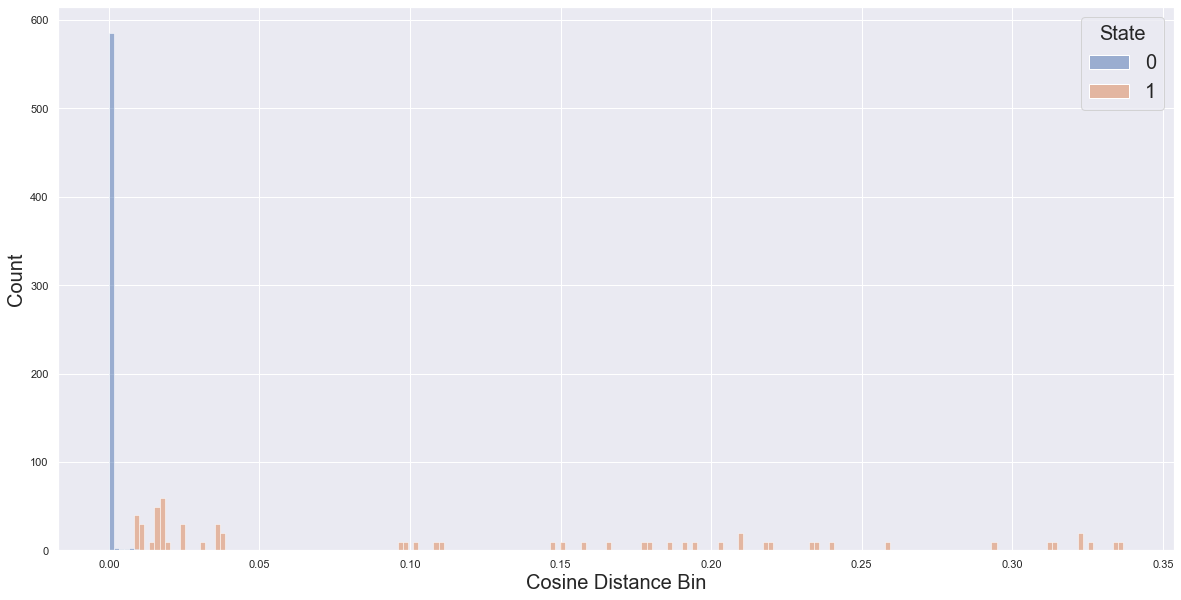

In [22]:
fig = plt.figure(figsize=(20, 10))
ax = fig.gca()
sns.histplot(data=hmmdf, x='cos_sim_diff', hue='state',
             stat='density',
             bins=200, ax=ax, 
             common_norm=False, kde=False)
#ax.set_ylim(0, 10)
ax.set_ylabel("Count", size=20)
ax.set_xlabel("Cosine Distance Bin", size=20)

legend = ax.get_legend()
handles = legend.legendHandles
legend.remove()
ax.legend(handles, [0, 1], title='State', fontsize=20, title_fontsize=20)

### Plot states

In [42]:
def plot_states(d, y='value_norm', state='state', time_field='time', cmap='tab10', 
                title=None, title_size=25, title_weight = 'bold', alpha=1, mk_alpha=1, 
                ax=None, legend=True, markers=False):
    if ax is None:
        ax = plt.gca()
    
    if isinstance(cmap, str):
        colors = cm.get_cmap(cmap).colors
    else:
        colors = cmap
        
    num_states = d[state].nunique()
    if num_states > len(colors):
        colors = [c for i, c in zip(range(num_states), cycle(colors))]
 
    transitions = [idx for idx, v in enumerate(d[state].diff()) if v != 0]
    for s, e in get_segments(transitions):
        clr_idx = d[state][s:e].unique().astype(int)[0]
        clr = colors[clr_idx]
        if e:
            ax.plot(d[time_field][s:e+1], d[y][s:e+1], c=clr, alpha=alpha)
        else:
            ax.plot(d[time_field][s:e], d[y][s:e], c=clr, alpha=alpha)
        if markers:    
            ax.scatter(d[time_field][s:e], d[y][s:e], color=clr, alpha=mk_alpha)
            
    if title:
        ax.set_title(title, fontsize=title_size, fontweight=title_weight)
        
    if legend:
        ax.legend(handles=[mpatches.Patch(color=c, label=s) for s, c in enumerate(colors[:num_states])],
                  loc='upper left',
                  ncol=1,
                  title='State',
                  fontsize=18,
                  title_fontsize=18)

In [43]:
def plot_hist(d, y='value_norm', state='state', time_field='time', cmap='tab10', 
              alpha=0.4, linewidth=0, ax=None):
    if ax is None:
        ax = plt.gca()
    
    if isinstance(cmap, str):
        colors = cm.get_cmap(cmap).colors
    else:
        colors = cmap
        
    num_states = d[state].nunique()
    if num_states > len(colors):
        colors = [c for i, c in zip(range(num_states), cycle(colors))]
        
    for st, group in d.groupby(state):
        if st == 0:
            sns.kdeplot(group[y], shade=True, vertical=True,
                        color=colors[st], legend=False, ax=ax, 
                        linewidth=linewidth, alpha=0.7)
        else:
            sns.kdeplot(group[y], shade=True, vertical=True,
                        color=colors[st], legend=False, ax=ax, 
                        linewidth=linewidth, alpha=alpha)
            ax.axhline(d.loc[d[state] == 1, y].mean(), 
                       color=colors[st],
                       linewidth=2,
                       linestyle='dashed')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 25)

In [44]:
def plot_states_hist(d, y='value_norm', state='state', time_field='time', figsize=(20, 7), return_fig=False, plot_kwargs={}, hist_kwargs={}):
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    cols = 5
    spec = gridspec.GridSpec(ncols=cols, nrows=1, figure=fig)
    ax1 = fig.add_subplot(spec[0, :(cols - 1)])
    ax2 = fig.add_subplot(spec[0, cols - 1])
    plot_states(d, y=y, state=state, time_field=time_field, ax=ax1, **plot_kwargs)
    plot_hist(d, y=y, state=state, ax=ax2, **hist_kwargs)
    ax2.get_yaxis().set_visible(False)
    ax2.set_ylim(ax1.get_ylim())
    ax1.set_xlabel("Elapsed Time", size=28)
    ax1.set_ylabel("Cosine distance (diff)", size=28)
    ax2.set_xlabel("Density", size=28)
    #ax2.axhline(d.query("state == 1")[y].median())
    
    if return_fig:
        return fig

In [56]:
model.means_.ravel()

array([4.53563923e-05, 1.85003821e-01])

In [57]:
hmmdf.query("state == 1")['cos_sim_diff'].mean()

0.1858583582164701

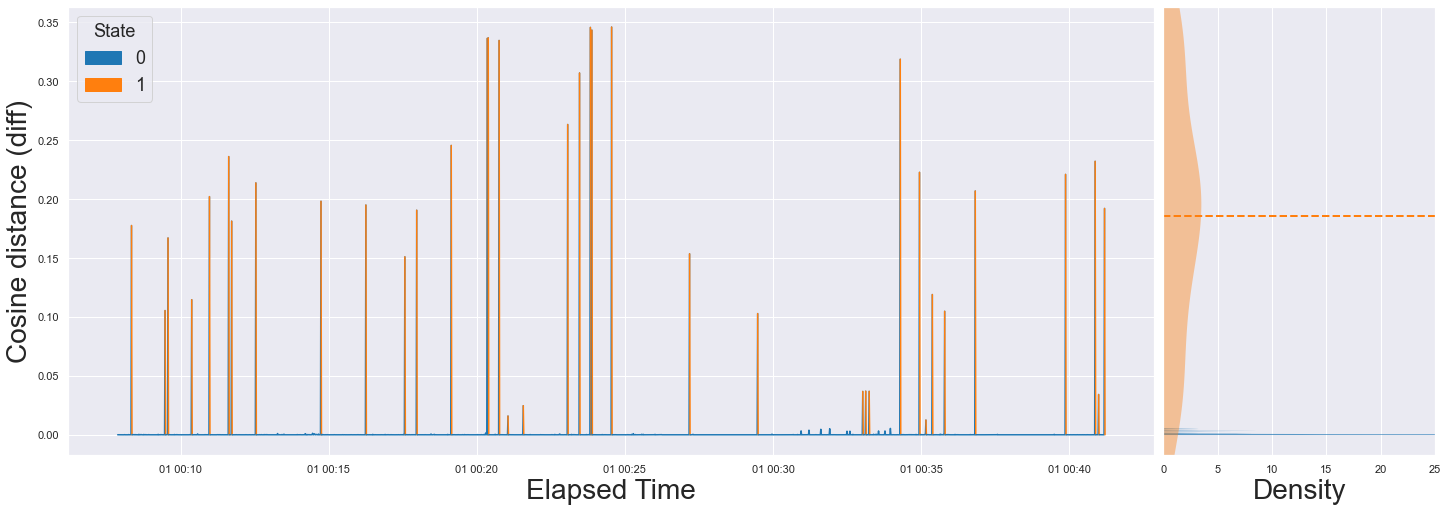

In [59]:
plot_states_hist(hmmdf, y='cos_sim_diff', state='state', time_field='elapsed_dt')
plt.savefig("thesis/mscs_thesis/figures/3_2_5_hmm_state_dist.pdf", dpi=300, bbox_inches='tight')

In [52]:
plot_states_hist_bokeh(hmmdf, y='cos_sim_diff', state='state', time_field='elapsed_dt')

# HMM vs Pecentile

In [20]:
ts = ddiffs.cos_sim_diff.to_numpy().reshape(-1,1)
model = hmm.GaussianHMM(n_components=2)
model.fit(ts)
signals = model.predict(ts)
np.unique(model.predict(ts), return_counts=True)

(array([0, 1], dtype=int32), array([1964,   38]))

In [21]:
p = figure(plot_width=1000, plot_height=300, x_axis_type='datetime')
p.line(ddiffs.elapsed_dt, ts.ravel(), line_width=2, line_alpha=0.5)
p.circle(ddiffs.loc[signals == 1, 'elapsed_dt'], ddiffs.loc[signals == 1, 'cos_sim_diff'], alpha=0.25, color='red')
if sldf is not None:
    for sc in sldf.change_time_dt:
        c = Span(location=sc, dimension='height', line_color='black', line_width=0.5)
        p.add_layout(c)
p.title.text = ""
#p.title.text = "HMM"
#p.title.text_font_size = '15pt'
p.xaxis.ticker = DatetimeTicker(desired_num_ticks=30, num_minor_ticks=10)
p.xaxis.formatter = DatetimeTickFormatter(minutes='%H:%M:%S', minsec='%H:%M:%S', hourmin='%H:%M:%S', seconds='%H:%M:%S', hours='%H')
p.xaxis.major_label_orientation = "vertical"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.xaxis.axis_label = "Elapsed Time"
p.xaxis.axis_label_text_font_size = "15pt"
p.yaxis.axis_label = "Cosine Distance (diff)"
p.yaxis.axis_label_text_font_size = "15pt"
p.output_backend = "svg"
export_svg(p, filename=f"thesis/mscs_thesis/figures/3_2_5_hmmpredict.svg")
show(p)

In [65]:
q = thresholds[meeting_id]
signals, threshold_q = get_signals(ddiffs, threshold_q=q)
print(f"Threshold is set at {threshold_q} percentile")

Threshold is set at 0.976021 percentile


In [66]:
kwargs = dict(plot_width=1000, 
              plot_height=300, 
              x_axis_type='datetime')
p = plot_slide_diffs(ddiffs, sldf=sldf, signals=signals, fig_kwargs=kwargs)
p.title.text = ""
p.legend.visible = False
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.xaxis.axis_label = "Elapsed Time"
p.xaxis.axis_label_text_font_size = "15pt"
p.yaxis.axis_label = "Cosine Distance"
p.yaxis.axis_label_text_font_size = "15pt"
#p.add_layout(p.legend[0], 'right')
#p.legend.location = "top_left"
show(p)